# Detection of Surgical Tools

Author: Francisco Mena

WORK IN PROGRESS

In this project I train a model to detect surgical tools in images
using two different approaches: start from scratch with an untrained model,
and transfer learning using a model that classifies images.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

In [2]:
print( tf.test.is_built_with_cuda() )
print( tf.config.list_physical_devices() )

tf.random.set_seed(42)



True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#Read annotations
folder = os.getcwd()

filesdir = folder + "\\Annotations\\"
files = os.listdir(filesdir)

In [5]:
import xml.etree.ElementTree as ET


lista = []
for i in range(len(files)):
    tree = ET.parse(filesdir + files[i])
    root = tree.getroot()
    #print( root[1].text )
    #rint( root[6][0].text)
    lista.append([root[1].text, root[6][0].text])

In [6]:
dflabels = pd.DataFrame(data = lista, columns=["image_name", "label"])
dflabels


,image_name,label
0,v01_002075.jpg,Grasper
1,v01_002250.jpg,Grasper
2,v01_002425.jpg,Grasper
3,v01_004050.jpg,Grasper
4,v01_004225.jpg,Grasper
...,...,...
2806,v10_065025.jpg,SpecimenBag
2807,v10_065125.jpg,SpecimenBag
2808,v10_065150.jpg,SpecimenBag
2809,v10_066100.jpg,SpecimenBag


In [7]:
#Read the tags for the splits

filesplit = folder + "\\ImageSets\\Main\\"
files = os.listdir(filesplit)
files

['test.txt', 'train.txt', 'trainval.txt', 'val.txt']

In [8]:
with open(filesplit + "train.txt") as f:
    train_names =  f.readlines()

#remove newline
train_names = [line.rstrip('\n') for line in train_names]
train_names[:5]

['v01_002250', 'v01_004225', 'v01_025150', 'v01_025800', 'v01_025975']

In [9]:
with open(filesplit + "val.txt") as f:
    val_names =  f.readlines()

#remove newline
val_names = [line.rstrip('\n') for line in val_names]
val_names[:5]

['v01_002425', 'v01_004050', 'v01_004625', 'v01_004800', 'v01_017125']

In [10]:
with open(filesplit + "test.txt") as f:
    test_names =  f.readlines()

#remove newline
test_names = [line.rstrip('\n') for line in test_names]
test_names[:5]

['v01_002075', 'v01_004450', 'v01_007125', 'v01_018000', 'v01_025625']

In [11]:
#Now to read the images, 3k images should fit in memory

imagefolder = folder + "\\JPEGImages\\"


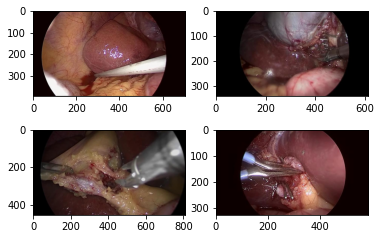

In [12]:
#train set
import cv2
import random

ii = 0
for image in random.sample(train_names, 4):

    input_img=cv2.imread(imagefolder + image + ".jpg" )
    im_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(2, 2, ii + 1)
    plt.imshow(im_rgb)
    ii+=1



In [13]:
train_set = []
train_label = []
for image in train_names:
    input_img=cv2.imread(imagefolder + image + ".jpg" )
    img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    height = img_rgb.shape[0]
    width = img_rgb.shape[1]

    #First I manually crop to square to avoid stretching when resizing
    img_rgb = img_rgb[:, (width-height)//2:(width+height)//2]

    img_resize=cv2.resize(img_rgb,(300,300)) #images have different sizes, need to resize

    img_resize = img_resize.astype("float32")/255.0 #normalize

    train_set.append( img_resize )
    #find label
    labl = dflabels.loc[dflabels["image_name"]==image + ".jpg", "label"].values[0]
    train_label.append(labl)

In [14]:
val_set = []
val_label = []
for image in val_names:
    input_img=cv2.imread(imagefolder + image + ".jpg" )
    img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    height = img_rgb.shape[0]
    width = img_rgb.shape[1]

    #First I manually crop to square to avoid stretching when resizing
    img_rgb = img_rgb[:, (width-height)//2:(width+height)//2]

    img_resize=cv2.resize(img_rgb,(300,300)) #images have different sizes, need to resize

    img_resize = img_resize.astype("float32")/255.0 #normalize

    val_set.append( img_resize )
    #find label
    labl = dflabels.loc[dflabels["image_name"]==image + ".jpg", "label"].values[0]
    val_label.append(labl)



In [15]:
#Data Augmentation to improve performance

#First, the functions


def augment(image, label):

    #Note: you can replace for stateless_random_brightness to set seed
    image = tf.image.random_brightness(image, max_delta=0.3) #random brightness
    image = tf.image.flip_left_right(image) #flip horizontally
    # image = tf.image.random_flip_up_down(image)   #Flipping upside down
    # image = tf.image.rot90(image)
    image = tf.clip_by_value(image, clip_value_min = 0, clip_value_max = 1)
    return image, label

Text(0.5, 1.0, 'Grasper')

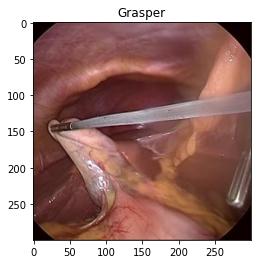

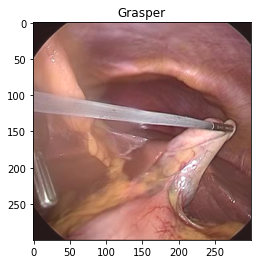

In [16]:
#Example

plt.figure()
plt.imshow(train_set[0])
plt.title(train_label[0])

img_aug, label_aug = augment(train_set[0], train_label[0])

plt.figure()
plt.imshow(img_aug)
plt.title(label_aug)


In [17]:
import time
#Let's choose random 500 images to train. Limit to 500 due to RAM limitations
np.random.seed(42)
idx = np.random.randint(0,len(train_label), 500)

for ii in idx:
    image, label = train_set[ii], train_label[ii]
    print(label)
    img_aug, label_aug = augment(image, label)
    train_set.append(img_aug)
    train_label.append(label_aug)
    #time.sleep(0.2)

Bipolar
Irrigator
Clipper
Bipolar
Irrigator
Irrigator
Bipolar
Grasper
Grasper
Scissors
Irrigator
Irrigator
Bipolar
SpecimenBag
Clipper
Clipper
Bipolar
Scissors
Irrigator
Scissors
SpecimenBag
Grasper
Clipper
Scissors
SpecimenBag
Scissors
Scissors
Clipper
Hook
Irrigator
Bipolar
Grasper
Scissors
Clipper
Grasper
SpecimenBag
Bipolar
Grasper
Bipolar
SpecimenBag
Grasper
Irrigator
Irrigator
SpecimenBag
Scissors
Bipolar
Scissors
Clipper
Scissors
Scissors
Clipper
Grasper
Grasper
Grasper
Hook
SpecimenBag
Scissors
Hook
Irrigator
Irrigator
Grasper
Grasper
Grasper
Grasper
Irrigator
Bipolar
Irrigator
Grasper
SpecimenBag
Bipolar
Clipper
Grasper
Bipolar
Scissors
Bipolar
Scissors
Clipper
Grasper
Clipper
SpecimenBag
Irrigator
Bipolar
Clipper
Grasper
Scissors
Irrigator
Irrigator
Irrigator
SpecimenBag
Grasper
SpecimenBag
Grasper
Clipper
Bipolar
Clipper
Scissors
SpecimenBag
Hook
Hook
Irrigator
SpecimenBag
Irrigator
Irrigator
Clipper
Grasper
Hook
Clipper
Grasper
Hook
Bipolar
Grasper
Irrigator
Clipper
Bipolar

In [18]:
#Now let's convert the list of arrays to the correct format for tensorflow

train_set = np.stack(train_set)
print( train_set.shape )
print( len(train_label) )

(1905, 300, 300, 3)
1905


In [19]:
val_set = np.stack(val_set)
print( val_set.shape )
print( len(val_label) )


(843, 300, 300, 3)
843


In [20]:

print( pd.Series(train_label).value_counts())


Irrigator      321
SpecimenBag    320
Clipper        295
Bipolar        294
Grasper        264
Hook           212
Scissors       199
dtype: int64


Somewhat low on scissors, let's see if it affects the performance of the model

In [21]:

#Convert labels to categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_label)
y_val = le.transform(val_label)


In [22]:
le.classes_
num_classes = len(le.classes_)
print(num_classes)


7


Now we build the arquitecture of the model with Tensorflow.

In [27]:
#Clear backend each time you run the model, avoid memory issues too
#import gc
#gc.collect()

keras.backend.clear_session()
np.random.seed(420)
tf.random.set_seed(420)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'elu',
                        kernel_regularizer = regularizers.l2(1e-4), input_shape = train_set.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'elu',
                        kernel_regularizer = regularizers.l2(1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu',
                        kernel_regularizer = regularizers.l2(1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'elu',
                        kernel_regularizer = regularizers.l2(1e-4)),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'elu', kernel_initializer="lecun_normal",
                       kernel_regularizer = regularizers.l2(1e-4)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation = 'softmax')
    ])

model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = "accuracy")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0

In [28]:
#Early stop to avoid overfitting
earlystop = tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True)

num_batch = 32
num_epochs = 100

history = model.fit(train_set, y_train,
                    validation_data= (val_set, y_val),
                    batch_size = num_batch,
                    epochs = num_epochs,
                    shuffle = True,
                    callbacks=[earlystop]
                    )

Epoch 1/100
60/60 [==============================] - 14s 195ms/step - loss: 3.6321 - accuracy: 0.2278 - val_loss: 10.4592 - val_accuracy: 0.1649
Epoch 2/100
60/60 [==============================] - 11s 176ms/step - loss: 2.4958 - accuracy: 0.2257 - val_loss: 26.4144 - val_accuracy: 0.1649
Epoch 3/100
60/60 [==============================] - 11s 182ms/step - loss: 2.4081 - accuracy: 0.2373 - val_loss: 14.4068 - val_accuracy: 0.1649
Epoch 4/100
60/60 [==============================] - 11s 187ms/step - loss: 2.4164 - accuracy: 0.2231 - val_loss: 13.1624 - val_accuracy: 0.1696
Epoch 5/100
60/60 [==============================] - 11s 184ms/step - loss: 2.2405 - accuracy: 0.2388 - val_loss: 14.0459 - val_accuracy: 0.1934
Epoch 6/100
60/60 [==============================] - 11s 179ms/step - loss: 2.1837 - accuracy: 0.2630 - val_loss: 10.8747 - val_accuracy: 0.2432
Epoch 7/100
60/60 [==============================] - 11s 177ms/step - loss: 2.1085 - accuracy: 0.2840 - val_loss: 12.5568 - val_ac

In [30]:
print("ready!")

ready!


<Figure size 576x576 with 0 Axes>

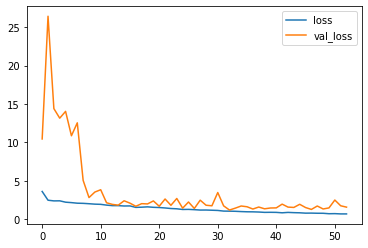

<Figure size 576x576 with 0 Axes>

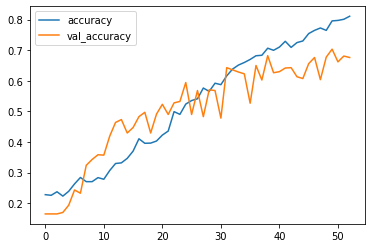

In [31]:
plt.figure(figsize = (8,8))
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
plt.show()

plt.figure(figsize = (8,8))
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()
plt.show()

Seems like the model won't continue improving with further training. Let's see other metrics of performance

In [33]:
# Now for the test set and measure performance!

test_set = []
test_label = []
for image in test_names:
    input_img=cv2.imread(imagefolder + image + ".jpg" )
    img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    height = img_rgb.shape[0]
    width = img_rgb.shape[1]

    #First I manually crop to square to avoid stretching when resizing
    img_rgb = img_rgb[:, (width-height)//2:(width+height)//2]
    img_resize=cv2.resize(img_rgb,(300,300)) #images have different sizes, need to resize

    img_resize = img_resize.astype("float32")/255.0

    test_set.append( img_resize )
    #find label
    labl = dflabels.loc[dflabels["image_name"]==image + ".jpg", "label"].values[0]
    test_label.append(labl)


In [34]:

test_set = np.stack(test_set)
print( test_set.shape )
print( len(test_label) )

y_test = le.transform(test_label)

(563, 300, 300, 3)
563


In [35]:
#Evaluation
model.evaluate(test_set, y_test)

18/18 [==============================] - 1s 77ms/step - loss: 1.3362 - accuracy: 0.5808


[1.3362011909484863, 0.5808170437812805]

In [36]:

from sklearn.metrics import classification_report

ypred = model.predict(test_set)
ypred = ypred.argmax(axis = 1)

print(classification_report(y_test, ypred, target_names = le.classes_))


              precision    recall  f1-score   support

     Bipolar       0.75      0.73      0.74        92
     Clipper       0.33      0.70      0.45        63
     Grasper       0.39      0.23      0.29        96
        Hook       0.49      0.61      0.55        64
   Irrigator       0.61      0.64      0.63        84
    Scissors       0.89      0.35      0.51        68
 SpecimenBag       0.86      0.80      0.83        96

    accuracy                           0.58       563
   macro avg       0.62      0.58      0.57       563
weighted avg       0.63      0.58      0.58       563



The model did well in Bipolar and SpecimenBag, but not very well with the Grasper or the Scissors, this last one possibly due to the small sample size. An accuracy of 57% is not amazing, but certainly better than the baseline of 1/7 = 14%

In [37]:
###Saving model
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model.save('saved_model/levita_model_' + timestamp)

INFO:tensorflow:Assets written to: saved_model/levita_model_20211215_1843\assets


Now let's see if we can do better with Transfer Learning!
Xception is a very powerful model trained with ImageNet. Let's see if we can use its weights to predict our classes.

In [32]:
#Xception needs data between -1 and 1, hence I need to rescale
train_set = train_set*2 - 1
val_set = val_set*2 - 1

In [33]:

import gc
gc.collect()

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)



base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape= train_set.shape[1:],
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=train_set.shape[1:])
# x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
#scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale= 2., offset=-1)
#x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation = "softmax")(x)
model_Xcpt = keras.Model(inputs, outputs)

model_Xcpt.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 14,343
Non-trainable params: 20,861,480
_________________________________________________________________


In [34]:
#Now we train the top layer

model_Xcpt.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics="accuracy",
)

num_epochs = 20


history_Xcpt = model_Xcpt.fit(train_set, y_train,
                    validation_data= (val_set, y_val),
                    batch_size = num_batch,
                    epochs = num_epochs,
                    shuffle = True,
                    # callbacks=[earlystop]
                    )

Epoch 1/20
60/60 [==============================] - 14s 227ms/step - loss: 1.5241 - accuracy: 0.4656 - val_loss: 1.2029 - val_accuracy: 0.6702
Epoch 2/20
60/60 [==============================] - 12s 199ms/step - loss: 1.0372 - accuracy: 0.6887 - val_loss: 0.9436 - val_accuracy: 0.7236
Epoch 3/20
60/60 [==============================] - 12s 199ms/step - loss: 0.8457 - accuracy: 0.7617 - val_loss: 0.8362 - val_accuracy: 0.7734
Epoch 4/20
60/60 [==============================] - 12s 199ms/step - loss: 0.7253 - accuracy: 0.7900 - val_loss: 0.7641 - val_accuracy: 0.7687
Epoch 5/20
60/60 [==============================] - 12s 201ms/step - loss: 0.6528 - accuracy: 0.8142 - val_loss: 0.6991 - val_accuracy: 0.7888
Epoch 6/20
60/60 [==============================] - 12s 202ms/step - loss: 0.5829 - accuracy: 0.8383 - val_loss: 0.6628 - val_accuracy: 0.7900
Epoch 7/20
60/60 [==============================] - 12s 203ms/step - loss: 0.5383 - accuracy: 0.8472 - val_loss: 0.6257 - val_accuracy: 0.7983

<Figure size 576x576 with 0 Axes>

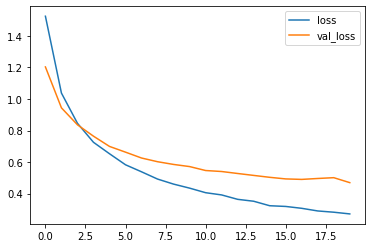

<Figure size 576x576 with 0 Axes>

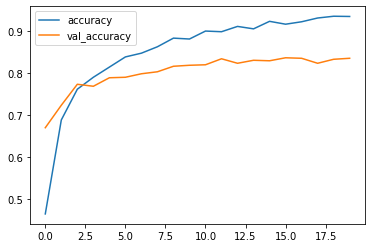

In [35]:
plt.figure(figsize = (8,8))
pd.DataFrame(history_Xcpt.history)[["loss", "val_loss"]].plot()
plt.show()

plt.figure(figsize = (8,8))
pd.DataFrame(history_Xcpt.history)[["accuracy", "val_accuracy"]].plot()
plt.show()

The divergence between training and validation accuracy indicate overfitting. Now one would unfreeze the model and retrain the entire network, but that implies some serious training time, out of the scope of this excercise. Still, the performance is significantly better:

In [36]:
model_Xcpt.evaluate(test_set, y_test)

18/18 [==============================] - 3s 167ms/step - loss: 0.5808 - accuracy: 0.7957


[0.5807809829711914, 0.7957371473312378]

80% accuracy!

In [37]:
from sklearn.metrics import classification_report

ypred = model_Xcpt.predict(test_set)
ypred = ypred.argmax(axis = 1)

print(classification_report(y_test, ypred, target_names = le.classes_))

              precision    recall  f1-score   support

     Bipolar       0.75      0.89      0.81        92
     Clipper       0.83      0.86      0.84        63
     Grasper       0.70      0.44      0.54        96
        Hook       0.85      0.88      0.86        64
   Irrigator       0.88      0.81      0.84        84
    Scissors       0.83      0.74      0.78        68
 SpecimenBag       0.77      1.00      0.87        96

    accuracy                           0.80       563
   macro avg       0.80      0.80      0.79       563
weighted avg       0.79      0.80      0.79       563



Now all classes have pretty high metrics, including the Scissors! Grasper could benefit from an increase of recall, but considering that this was a simple approach of transfer learning, it's a great result.

In [38]:
# tiempo de ejecucion
start = datetime.now()
model_Xcpt.predict(test_set)
end = datetime.now()

print(end - start)



0:00:02.454052


In [39]:
#Time the model takes to predict
len(test_set)/2.452948


229.5197452208526